# Traffic Signs Recognition using CNN

In [32]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
# from keras.models import Sequential, load_model
# from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras import layers, models
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from china.china_dataset_reader import load_traffic_sign_dataset
from india.india_dataset_reader import load_india_dataset


code reference:

https://github.com/deepak2233/Traffic-Signs-Recognition-using-CNN-Keras/blob/main/Model/Traffic%20Signs%20Recognition%20using%20CNN%20%26%20Keras%20with%2098%25%20Accuracy.ipynb

https://www.kaggle.com/code/osamaabidoo/98-accuracy-on-german-traffic-sign-recognition

## GTSRB Dataset Overview

In [3]:
# Train.csv
train_csv_path = os.getcwd() + "\dataset\Train.csv"
train_df = pd.read_csv(train_csv_path, usecols=['ClassId', 'Path', 'Width', 'Height'])
train_df.head()

,Width,Height,ClassId,Path
0,27,26,20,Train/20/00020_00000_00000.png
1,28,27,20,Train/20/00020_00000_00001.png
2,29,26,20,Train/20/00020_00000_00002.png
3,28,27,20,Train/20/00020_00000_00003.png
4,28,26,20,Train/20/00020_00000_00004.png


In [4]:
# Test.csv
test_csv_path = os.getcwd() + "\dataset\Test.csv"
test_df = pd.read_csv(test_csv_path, usecols=['ClassId', 'Path', 'Width', 'Height'])
test_df.head()

,Width,Height,ClassId,Path
0,53,54,16,Test/00000.png
1,42,45,1,Test/00001.png
2,48,52,38,Test/00002.png
3,27,29,33,Test/00003.png
4,60,57,11,Test/00004.png


In [5]:
# GTSRB Label Overview (from Kaggle)
GTSRB_classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Load the GTSRB


In [6]:
train_data = [] # X_train
train_labels = [] # X_test
classes = 43
train_path = os.getcwd() + "\dataset\Train"

for i in os.listdir(train_path):
    dir = train_path + '/' + i
    if os.path.isdir(dir):
        for j in os.listdir(dir):
            try:
                img_path = dir+ '/' +j
                img = cv2.imread(img_path,-1)
                # resize all images to 30,30
                img = cv2.resize(img, (30,30), interpolation = cv2.INTER_NEAREST)
                train_data.append(img)
                train_labels.append(i)
            except Exception as e:
                print(e)    
train_data = np.array(train_data)
train_labels = np.array(train_labels)
print(train_data.shape, train_labels.shape)

(39209, 30, 30, 3) (39209,)


In [7]:
test_data = [] # y_train
test_labels = [] # y_test
test_path = os.getcwd() + "\dataset\Test"

for index, row in test_df.iterrows():
    img_path = os.getcwd() + "\dataset/" + row['Path']
    img = cv2.imread(img_path, -1)
    img = cv2.resize(img, (30,30), interpolation=cv2.INTER_NEAREST)
    test_data.append(img)
    test_labels.append(row['ClassId'])

test_data = np.array(test_data)
test_labels = np.array(test_labels)
print(test_data.shape, test_labels.shape)

(12630, 30, 30, 3) (12630,)


## Visualize Train Data in GTSRB

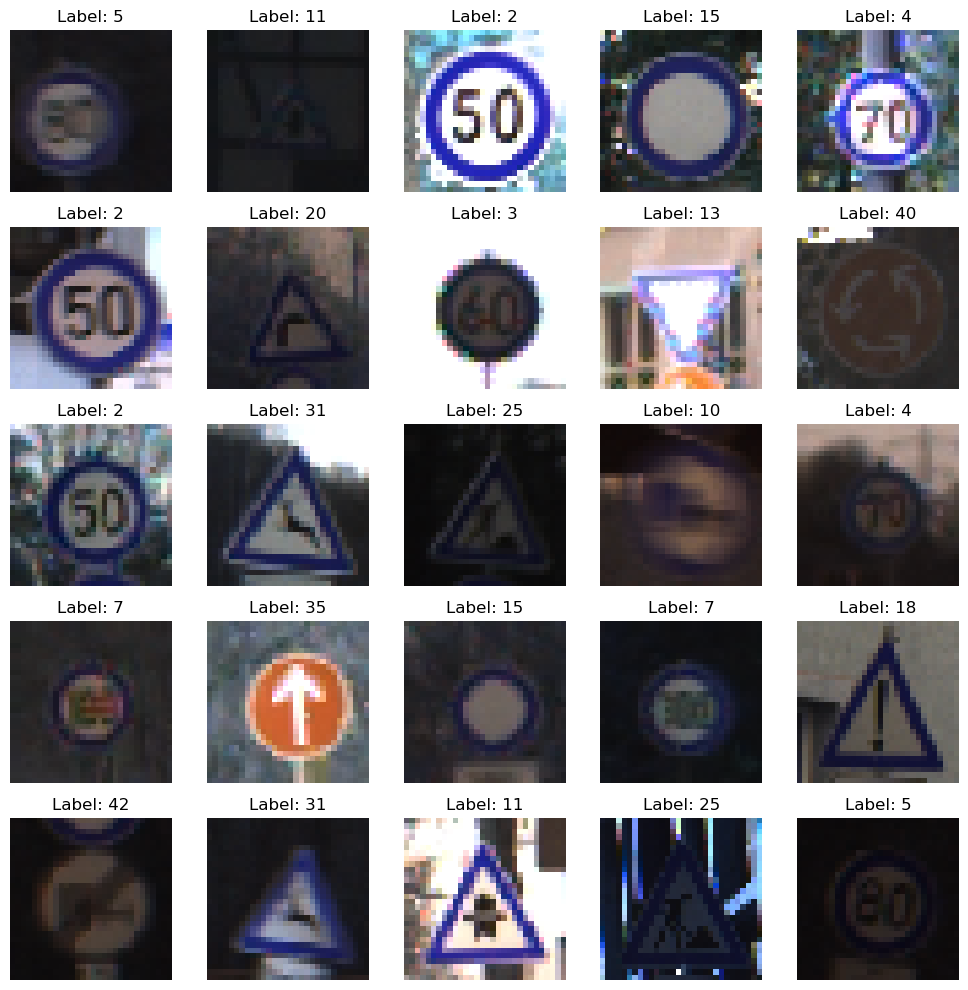

In [8]:
random_indices = random.sample(range(len(train_data)), 25)
# randomly plot 25 images from train_data[]
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        index = random_indices[i * 5 + j]
        # Display the image
        axs[i, j].imshow(train_data[index])
        axs[i, j].axis('off')
        # Display the corresponding label
        axs[i, j].set_title(f"Label: {train_labels[index]}")
plt.tight_layout()
plt.show()


## Load Chinese Traffic Sign Dataset

In [9]:
china_images, china_categories = load_traffic_sign_dataset()
print(china_images.shape)
print(china_categories.shape)

CSV Path: c:\Users\anson\23T2\cs9444\comp9444-project\china\annotations.csv
(6164, 30, 30, 3)
(6164,)


In [10]:
def plot_classes_with_images(images, categories, num_classes=5, images_per_row=7):
    unique_categories = np.unique(categories)
    num_rows = -(-num_classes // images_per_row)  # Ceil division to calculate the number of rows

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(20, num_rows * 4))

    for i in range(num_rows):
        for j in range(images_per_row):
            index = i * images_per_row + j
            if index < num_classes:
                class_category = unique_categories[index]
                class_images = images[categories == class_category]

                # Randomly select an image from the class
                random_image = random.choice(class_images)

                axes[i, j].imshow(random_image)
                axes[i, j].set_title(f'Class {class_category}')
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')  # Hide empty subplots

    plt.show()


In [11]:
# plot_classes_with_images(china_images, china_categories, 58)

In [12]:
# plot_classes_with_images(train_data, train_labels, 43)

In [13]:
# manually label the classes in chinese dataset
# labelled based on the name on https://en.wikipedia.org/wiki/Road_signs_in_China
china_classes = { 0:'Speed limit (5km/h)',
                1:'Speed limit (15km/h)', 
                2:'Speed limit (30km/h)', 
                3:'Speed limit (40km/h)', 
                4:'Speed limit (50km/h)', 
                5:'Speed limit (60km/h)', 
                6:'Speed limit (70km/h)', 
                7:'Speed limit (80km/h)', 
                8:'No proceed straight and left turns', 
                9:'No proceed straight and right turns', 
                10:'No proceed straight', 
                11:'No left turn', 
                12:'No left and right turns', 
                13:'No right turn', 
                14:'No overtaking', 
                15:'No U-turns', 
                16:'No motor vehicles', 
                17:'No honking', 
                18:'End of speed limit (40km/h)', 
                19:'End of speed limit (50km/h)', 
                20:'Go straight or right', 
                21:'Ahead only', 
                22:'Turn left ahead', 
                23:'Go left or right', 
                24:'Turn right ahead', 
                25:'Keep left', 
                26:'Keep right', 
                27:'Roundabout mandatory', 
                28:'Lane for automobile', 
                29:'Honking', 
                30:'Bicycles only',
                31:'U-turn', 
                32:'Turn left and/or right to detour', 
                33:'Traffic signals', 
                34:'General caution', 
                35:'Pedestrian crossing ahead', 
                36:'Bicycles crossing', 
                37:'Children crossing', 
                38:'Dangerous curve right', 
                39:'Dangerous curve left', 
                40:'Steep descent', 
                41:'Steep ascent', 
                42:'Tunnel ahead', # not sure
                43:'Side road junction ahead on the right',
                44:'Side road junction ahead on the left',
                45:'Cross-village road',
                46:'Double curve, with turn right first, then left', # GTSRB has a general version double curve, should i merge them?
                47:'Railroad crossing ahead (without safety barriers)',
                48:'Road work',
                49:'Multiple curves',
                50:'Railroad head (with safety barriers)',
                51:'Accident area',
                52:'Stop',
                53:'No vehicles',
                54:'No stopping',
                55:'No entry',
                56:'Yield',
                57:'Control' }

## Merge GTRSB and Chinese dataset

In [14]:
# helper function to merge two classes dict together
def merge_classes(classes1, classes2):
    merged_classes = {}
    used_values = set()

    for key1, value1 in classes1.items():
        if value1.lower() not in used_values:
            merged_classes[key1] = value1
            used_values.add(value1.lower())

    for key2, value2 in classes2.items():
        if value2.lower() not in used_values:
            merged_classes[max(merged_classes.keys()) + 1] = value2
            used_values.add(value2.lower())

    return merged_classes

In [15]:
# function to merge two dataset together 
def merge_datasets(dataset1_data, dataset1_labels, dataset1_classes, dataset2_data, dataset2_labels, dataset2_classes):
    merged_data = []
    merged_labels = []
    
    class_mapping = merge_classes(dataset1_classes, dataset2_classes)
    
    def find_key_by_value(dict, target_value):
        for key, value in dict.items():
            if value.lower() == target_value.lower():
                return key

    # Merge the datasets based on class mapping
    for data, label in zip(dataset1_data, dataset1_labels):
        value = dataset1_classes.get(int(label))
        new_key = find_key_by_value(class_mapping, value)
        merged_labels.append(new_key)
        merged_data.append(data)

    for data, label in zip(dataset2_data, dataset2_labels):
        value = dataset2_classes.get(int(label))
        new_key = find_key_by_value(class_mapping, value)
        merged_labels.append(new_key)
        merged_data.append(data)

    return np.array(merged_data), np.array(merged_labels), class_mapping


# merge GTRSB train and test data back together
GTRSB_data = np.concatenate([train_data, test_data], axis=0)
GTRSB_labels = np.concatenate([train_labels, test_labels], axis=0)
# merge GTRSB and Chinese dataset
merged_data, merged_labels, merged_class_mapping = merge_datasets(GTRSB_data, GTRSB_labels, GTSRB_classes, china_images, china_categories, china_classes)

# Display the merged dataset shapes
print("Merged Dataset Shapes:")
print("Merged Data Shape:", merged_data.shape)
print("Merged Labels Shape:", merged_labels.shape)

# Display the class mapping after merging
print("Class Mapping After Merging:")
for key, value in merged_class_mapping.items():
    print(f"{key}: {value}")

Merged Dataset Shapes:
Merged Data Shape: (58003, 30, 30, 3)
Merged Labels Shape: (58003,)
Class Mapping After Merging:
0: Speed limit (20km/h)
1: Speed limit (30km/h)
2: Speed limit (50km/h)
3: Speed limit (60km/h)
4: Speed limit (70km/h)
5: Speed limit (80km/h)
6: End of speed limit (80km/h)
7: Speed limit (100km/h)
8: Speed limit (120km/h)
9: No passing
10: No passing veh over 3.5 tons
11: Right-of-way at intersection
12: Priority road
13: Yield
14: Stop
15: No vehicles
16: Veh > 3.5 tons prohibited
17: No entry
18: General caution
19: Dangerous curve left
20: Dangerous curve right
21: Double curve
22: Bumpy road
23: Slippery road
24: Road narrows on the right
25: Road work
26: Traffic signals
27: Pedestrians
28: Children crossing
29: Bicycles crossing
30: Beware of ice/snow
31: Wild animals crossing
32: End speed + passing limits
33: Turn right ahead
34: Turn left ahead
35: Ahead only
36: Go straight or right
37: Go straight or left
38: Keep right
39: Keep left
40: Roundabout manda

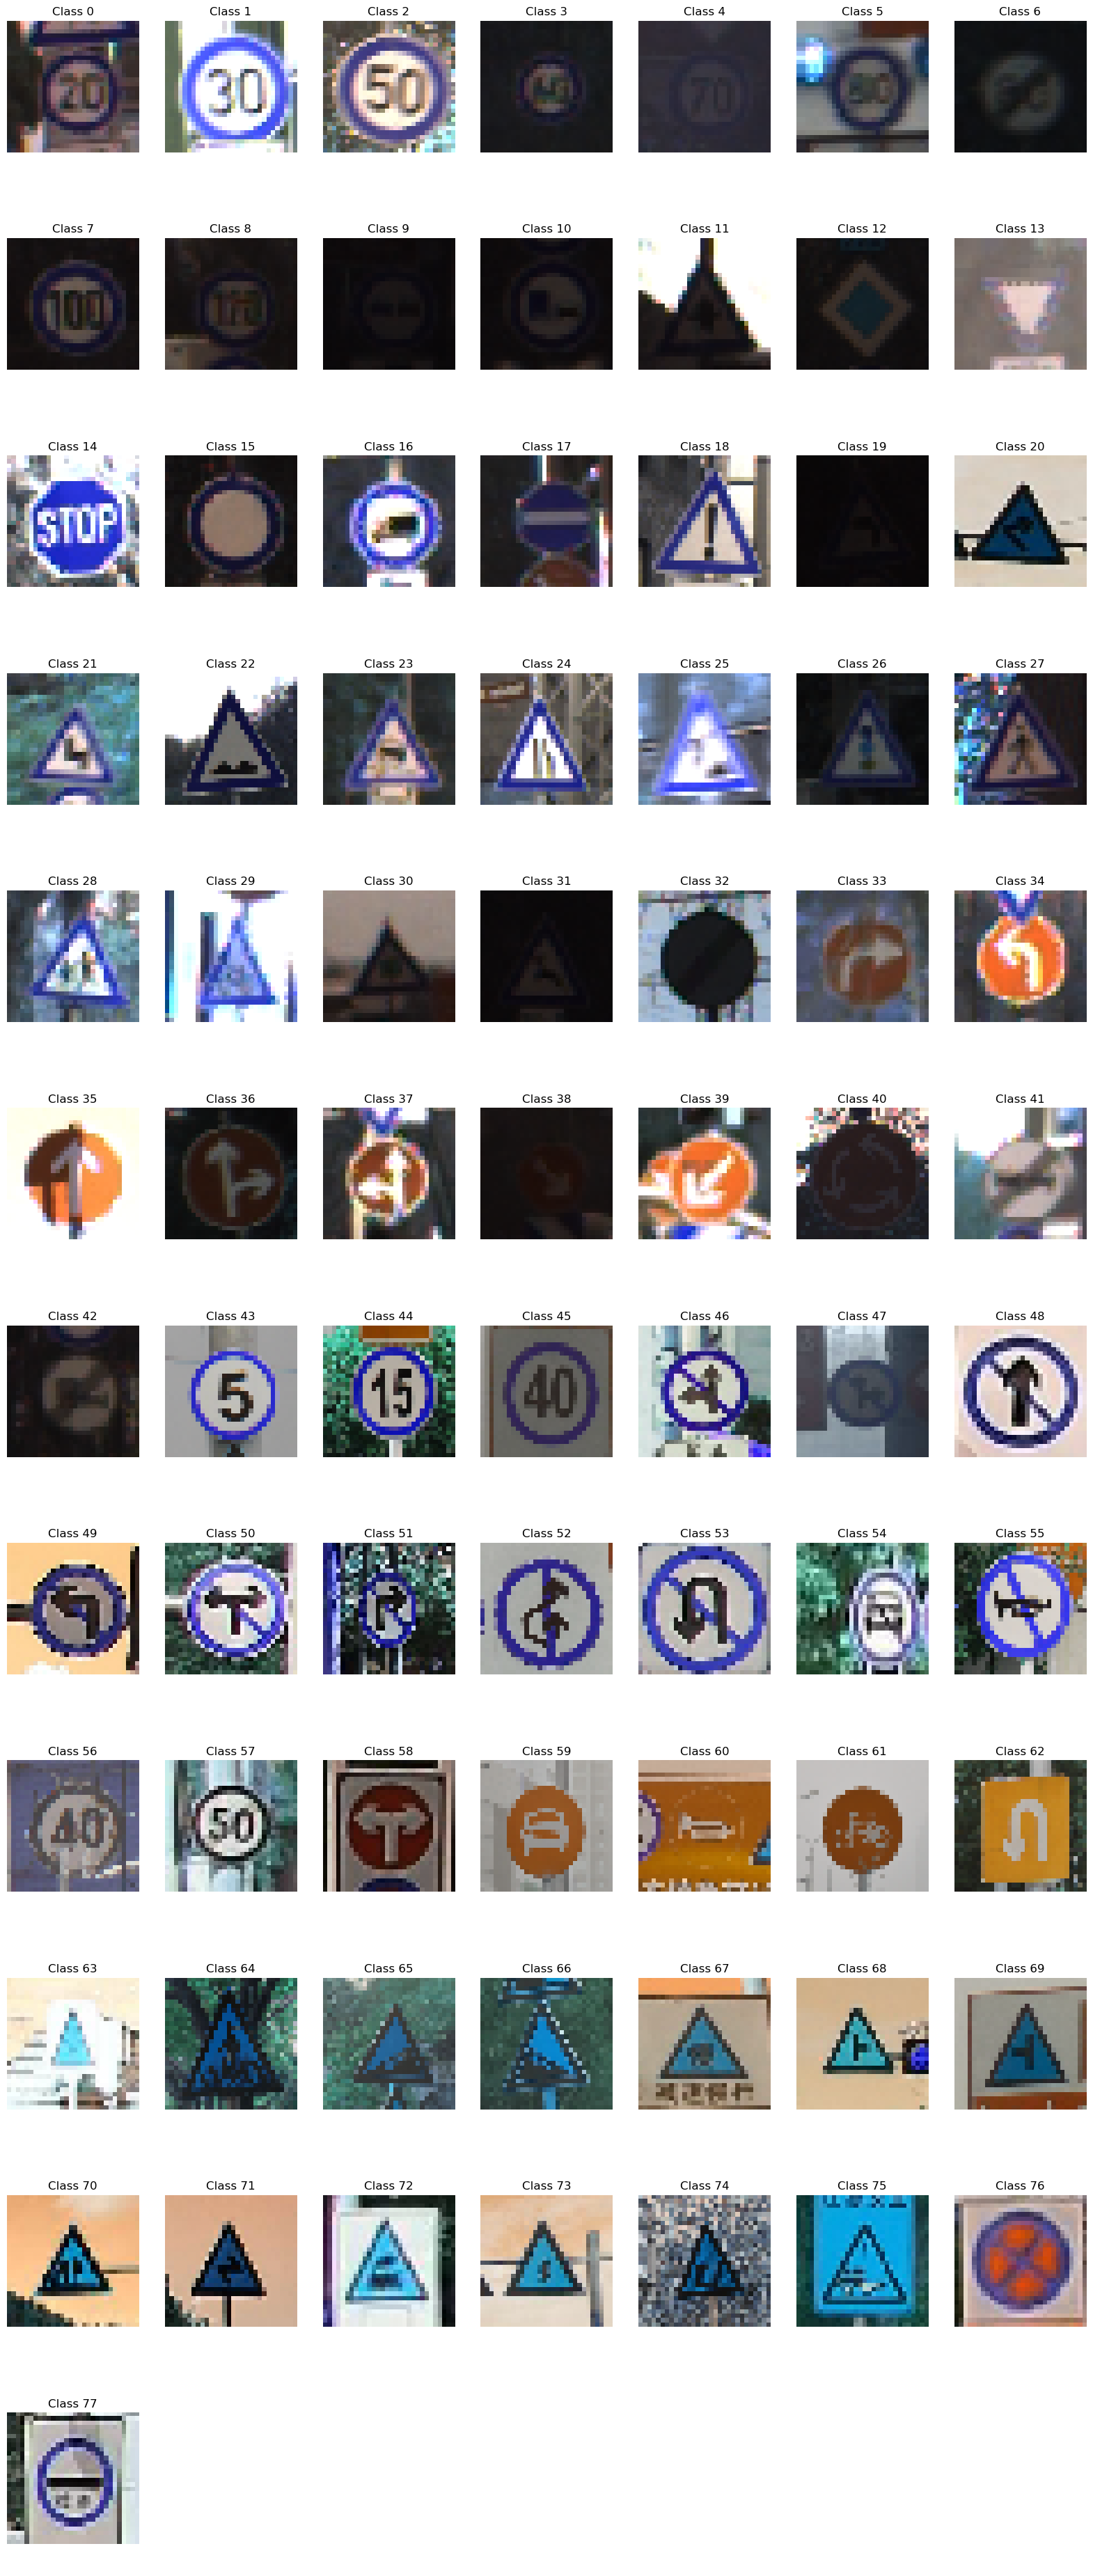

In [16]:
plot_classes_with_images(merged_data, merged_labels, 78)

## Load the India Dataset 

In [33]:
India_train, India_label = load_india_dataset()
print(India_train.shape, India_label.shape)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (10584, 30, 30) + inhomogeneous part.

In [18]:
# manually label 
india_classes = {
      0:'Yield',
      1:'No proceed straight',
      2:'One-way traffic',
      3:'One-way traffic',
      4:'No vehicles in both directions',
      5:'No entry for cycles',
      6:'No entry for goods vehicles',
      7:'No entry for pedestrians',
      8:'No entry for bullock carts',
      9:'No entry for hand carts',
      10:'No motor vehicles',
      11:'Height limit',
      12:'Weight limit',
      13:'Axle weight limit',
      14:'Length limit',
      15:'No left turn',
      16:'No right turn',
      17:'No overtaking',
      18:'Speed limit (90 km/h)',
      19:'Speed limit (110 km/h)',
      20:'No honking',
      21:'No parking',
      22:'No stopping',
      23:'Turn left ahead',
      24:'Turn right ahead',
      25:'Steep descent',
      26:'Steep ascent',
      27:'Road narrows on the right',
      28:'Narrow bridge',
      29:'Unprotected quay',
      30:'Road hump',
      31:'Bumpy road',
      32:'Loose gravel',
      33:'Falling rocks',
      34:'Wild animals crossing',
      35:'Crossroads',
      36:'Side road junction',
      37:'Oblique side road junction',
      38:'T-junction',
      39:'Y-junction',
      40:'Staggered side road junction',
      41:'Roundabout mandatory',
      42:'Railroad head (with safety barriers)',
      43:'Unguarded level crossing ahead',
      44:'Parking',
      45:'Bus stop'
}

## Split Train Data

In [19]:
# Converting labels into one hot encoding 
train_labels = to_categorical(train_labels, 43)
test_labels = to_categorical(test_labels, 43)

In [20]:
# Normalize pixel values to be between 0 and 1
train_data = train_data / 255.0
# will modify the splitting latter to create train and test set
# Split the data into training and validation sets (80%, 20%)
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

In [21]:
# first attempt, please modify 
model = models.Sequential([
    layers.InputLayer(input_shape=(30, 30, 3)), 
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(43, activation='softmax')  # 43 classes
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 256)               8

In [22]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
model.save("traffic_sign_model")

Epoch 1/10
901/981 [==========================>...] - ETA: 0s - loss: 1.0030 - accuracy: 0.7230

KeyboardInterrupt: 

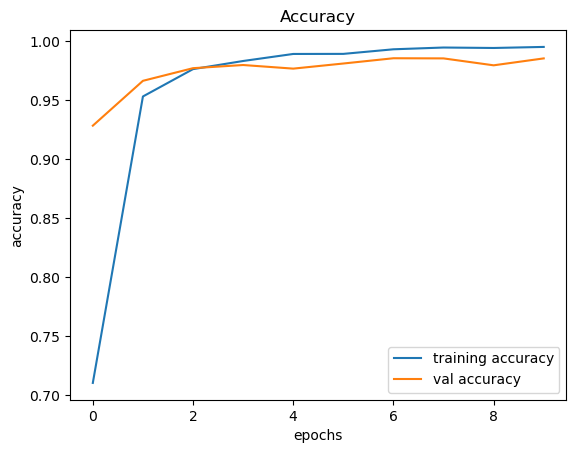

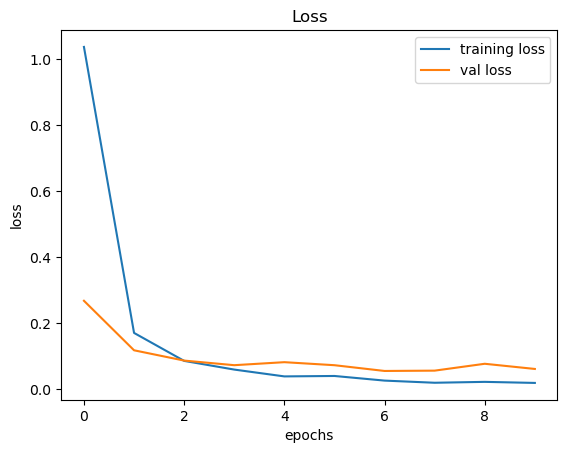

In [ ]:
# plotting graphs for accuracy 
# https://github.com/deepak2233/Traffic-Signs-Recognition-using-CNN-Keras/blob/main/Model/Traffic%20Signs%20Recognition%20using%20CNN%20%26%20Keras%20with%2098%25%20Accuracy.ipynb
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Loss 
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Evaluation

In [ ]:
# evaluate on test set
y_pred = model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

def print_metrics(y_true, y_pred):
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred, zero_division=1))

print_metrics(y_true, y_pred)

395/395 [==============================] - 1s 2ms/step
Confusion Matrix:
 [[ 49   8   0 ...   0   0   0]
 [  3 701   1 ...   0   0   0]
 [  3  34 669 ...   4   0   0]
 ...
 [  0   0   0 ...  75   0   0]
 [  0   0   0 ...   0  48   0]
 [  0   0   0 ...   2   3  84]]
Accuracy: 0.8980997624703088
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.82      0.74        60
           1       0.89      0.97      0.93       720
           2       0.97      0.89      0.93       750
           3       0.81      0.84      0.82       450
           4       0.92      0.93      0.93       660
           5       0.86      0.90      0.88       630
           6       0.98      0.70      0.82       150
           7       0.92      0.82      0.86       450
           8       0.93      0.80      0.86       450
           9       0.91      0.94      0.92       480
          10       1.00      0.93      0.96       660
          11       0.88      0.8